In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

#Question 2


Here we provide an autograd class named Value. The basic idea is to store the computational map during the creation of every Values, and calculate the gradient by back propagation when one of the Value called backwards method.

The backward function with the function of building the computational graph is handled, all you need to do is to implement all the operations with its corresponding backwards function, the add function is implemented as an example.

In [2]:
class Value:
    '''basic unit of storing a single scalar value and its gradient'''
    def __init__(self, data, _children=()):
      self.data = data
      self.grad = 0
      self._prev = set(_children)
      self._backward = lambda: None

    def get_data(self):
      return self.data

    def get_grad(self):
      return self.grad
    
    def __add__(self, other):
      '''we provided you a example of implementation of a operation here'''

      #Firstly, convert some default value type in python to Value
      #Then do operations with two or more Value object
      other = other if isinstance(other, Value) else Value(other)

      #Secondly, create a new Value object which is the result of the operation 
      out = Value(self.data + other.data, (self, other))

      #Thirdly, create a _backwards function for the output object to refresh the gradient of its _childrens, 
      #Then assign this _backwards function to the output object.
      def _backward():
        self.grad += out.grad
        other.grad += out.grad
      out._backward = _backward

      return out

    def __mul__(self, other):
      ''' Computes Multiplication operation'''

      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other))

      def _backward():
        self.grad += out.grad * other.data
        other.grad += out.grad * self.data
      out._backward = _backward

      return out
    
    def __pow__(self, other):
      ''' Computes power operation'''

      assert isinstance(other, (int, float))
      oth = float(other)
      out = Value(np.power(self.data, oth), (self,))

      def _backward():
        self.grad += out.grad * oth * np.power(self.data, oth - 1)
      out._backward = _backward

      return out
    
    def relu(self):
      ''' Computes relu operation'''

      out = Value(max(self.data, 0), (self,))

      def _backward():
        if self.data > 0:
          self.grad += out.grad 
      out._backward = _backward

      return out
    
    
    def exp(self):
      ''' Computes exponential operation'''

      out = Value(np.exp(self.data), (self,))

      def _backward():
        self.grad += out.grad * np.exp(self.data)
      out._backward = _backward

      return out
    
    def log(self):
      ''' Computes exponential operation'''

      out = Value(np.log(self.data), (self,))

      def _backward():
        self.grad += out.grad / self.data
      out._backward = _backward

      return out

    def backward(self):
      #This function is called when you start backpropagation from this Value
      
      #The gradient of this value is initialized to 1 for you.
      self.grad = 1

      #You need to find a right topological order all of the children in the graph
      topo = []
      #Implement a BFS that can visit a node multple times (if the node is used as an operand in multiple operations)
      t = [self]

      while t:
        n = t.pop(0)
        prev = list(n._prev)
        if n in topo:
          topo.remove(n)
        topo = topo + [n]
        t = t + list(n._prev) 

      #go one variable at a time and apply the chain rule to get its gradient        
      for v in topo:
          v._backward()
          # print(v)

    # we handled those negative and reverse operation for you.
    def __neg__(self): # -self
      return self * -1

    def __radd__(self, other): #other + self
      return self + other
    
    def __sub__(self, other): # self - other
      return self + (-other)
    
    def __rsub__(self, other): # other - self
      return other + (-self)
    
    def __rmul__(self, other): # other * self
      return self * other
    
    def __truediv__(self, other): # self / other
      return self * other**-1
    
    def __rtruediv__(self, other): # other / self
      return other * self**-1
    
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

Now, we are going to use the simple example in the q1.b to get you familar with the usage of this class.

Also you will be able to see whether the some of the operations appeared in this example are correctly implemented.

In [3]:
w1 = Value(0.3)
w2 = Value(-0.5)
x1 = Value(0.2)
x2 = Value(0.4)

#TODO
#Do calculation for the question 1.b, and call backward to start backpropagation.
#Then print out the gradient of w1 w2 x1 x2.
f = 1 / (1 + Value.exp(-(w1*x1 + w2*x2))) + 0.5 * (w1 ** 2 + w2 **2)
f.backward()


print("f value:", f.data)
print("w1 grad:", w1.grad)
print("w2 grad:", w2.grad)
print("x1 grad:", x1.grad)
print("x2 grad:", x2.grad)

f value: 0.6350570548417855
w1 grad: 0.34975579811673396
w2 grad: -0.400488403766532
x1 grad: 0.074633697175101
x2 grad: -0.124389495291835


#Question 3


##Implementation of the linear layer
You will implement the linear layer module here

We provide the initialization of the class LinearLayer and you need to implement the forward function -- Give out the results - `out` with the shape `[n_samples, n_out_channels]` of a linear layer when the the data `x` shaped `[n_samples, n_in_channels]` is fed into it.
 

In [4]:
class Module:
  def parameters(self):
    return []

  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0

class LinearLayer(Module):
  def __init__(self, nin, nout):
    '''Here we randomly initilized the w as 2-dimensional list of Values'''
    '''And b as 1-dimensional list of Values with value 0'''
    '''You may use this stucture to implement the __call__ function'''
    self.w = []
    for i in range(nin):
      w_tmp = [Value(random.uniform(-1,1)) for j in range(nout)]
      self.w.append(w_tmp)
    self.b = [Value(0) for i in range(nout)]
    self.nin = nin
    self.nout = nout
  
  def __call__(self, x):
    '''x is a two dimensional list of Values with shape (batch_size , nin)'''
    '''The output should be a two dimensional list of Values with shape (batch_size, nout)'''

    w_np = np.array(self.w)
    x_np = np.array(x)
    b_np = np.array(self.b)

    return (x_np @ w_np + b_np).tolist()
  
  def parameters(self):
    return [p for row in self.w for p in row] + [p for p in self.b]

##Implementation of usage functions
you will implement softmax, cross entropy loss, accuracy here for further use

In [5]:
def softmax(y_hat):
  """
    y_hat is the 2-dimensional list of Values with shape (batch_size, n_class)
    
    the output should also be 2-dimensional list of Values with the same shape as y_hat
  """

  vexp = np.vectorize(Value.exp)
  exps = vexp(y_hat)
  sums = np.sum(exps, axis=1, keepdims=True)
  softmax = exps / sums

  return softmax

In [6]:
def cross_entropy_loss(y_hat, y):
    """
    y_hat is the output from linear function with shape (batch_size, n_class)
    y is list of labels (batch_size)

    the output should be a Value.
    """

    vlog = np.vectorize(Value.log)
    logs = vlog(y_hat)

    ohe = np.zeros((len(y), max(y)+1))
    ohe[np.arange(len(y)), y] = 1

    loss = np.sum(ohe * logs)
    return -loss / len(y)

In [7]:
def accuracy(y_hat, y):
    """
    y_hat is the output from linear function with shape (batch_size, n_class)
    y is a list of labels (batch_size)

    the output should be a float value 
    """

    vdata = np.vectorize(Value.get_data)
    pred = np.argmax(vdata(y_hat), axis=1)
    correct = (pred == y).sum()
    
    return correct / len(y)

Implement the following functions to visualize the ground truth and the decision boundary to in the same figure.

In [8]:
def plot_points (X, Y, scale, n, data):
    '''
    plot points in the virtualization image
    '''
    points_color = [[0., 0. , 255.], [255., 0., 0.], [0., 255., 0.],[0., 0. , 0.]]

    x = (X + scale) / (2 * scale) * n
    x = np.rint(x)
    x = x.astype(np.int)
    Y = Y.astype(np.int)
    
    for i in range(X.shape[0]):
      data[x[i,0]][x[i,1]] = points_color[Y[i]]

    return data


def plot_background (scale, n, model):
    '''
    color background in the virtualization image
    '''

    background_color = [[0., 191., 255.], [255., 110., 180.], [202., 255., 112.],[156., 156., 156.]]
   
    data = np.zeros((n,n,3), dtype='uint8')
    vdata = np.vectorize(Value.get_data)
    
    # k = 100
    for i in range(n):
        x1 = -scale + 2 * scale / n * i
        for j in range(n):
            x2 = -scale + 2 * scale / n * j
            input = [[Value(x1),Value(x2)]]
            #TODO using the model to predict a class for the input and assign a color to "data" at this position.
            logits = model(input)
            y_hat = softmax(logits)
            pred = np.argmax(vdata(y_hat))
            # print(pred)
            # data[input] = background_color[pred]
            data[i][j] = background_color[pred]
    return data


def virtualization(X, Y, model):

    scale = 4.5  # the scale of X axis and Y axis. To say, x is from -scale to +scale
    n = 300      # seperate the image into n*n pixels 

    # data = np.ones((n,n,3), dtype='uint8')
    data = plot_background (scale, n, model)
    data = plot_points (X, Y, scale, n, data)
    
    plt.imshow(data)
    plt.axis('off')
    plt.show()

##Implementation of training procedure
With input data `x`, ground_truth `y`, and `model` as parameters, implement the gradient descent method to train your model and plot loss and accuracy vs the training iterations

In [9]:
def train(x, y, model, loss_function=cross_entropy_loss, accuracy_function=accuracy, max_iteration=500, learning_rate=1):
    '''
       x 2-d list of Values with shape: [n_samples, n_channels]
       y 1-d list of integers with shape: [n_samples]
    '''
    for i in range(max_iteration):
        #Set gradients to 0 to prevent accumulation
        model.zero_grad()

        #Calculate estimated labels, loss, and accuracy
        logits = model(x)
        y_hat = softmax(logits)
        loss = cross_entropy_loss(y_hat, y)
        acc = accuracy(y_hat, y)

        #TODO Then You will need to calculate gradient for all parameters, and do gradient descent for all the parameters.
        #The list of parameters can be easily obtained by calling mode.parameters() which is implemented above.
        loss.backward()
        params = model.parameters()
        for p in params:
          p.data = p.data - learning_rate * p.grad
        
        #Then plot the loss / accuracy vs iterations.
        if i % 20 == 19:
            print("iteration",i,"loss:",loss.data, "accuracy:",acc)
        ## record loss
        if i == 0 :
        # initialize L
            L = loss.data
            A = acc
        else:
            L = np.append(L,loss.data)
            A = np.append(A,acc)
    
    ## plot the loss function
    fig0=plt.figure(0)
    plt.plot(L,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    fig1=plt.figure(1)
    plt.plot(A,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.show()


##Train the model
load the data, format it, instantiate your model and start training!

(100, 2) (100,) [0 1 2 3]
iteration 19 loss: 1.18673237419827 accuracy: 0.37
iteration 39 loss: 0.996502653314012 accuracy: 0.72
iteration 59 loss: 0.8855190341166934 accuracy: 0.82
iteration 79 loss: 0.8049579146732265 accuracy: 0.86
iteration 99 loss: 0.7428363218344581 accuracy: 0.89
iteration 119 loss: 0.6932017930904509 accuracy: 0.94
iteration 139 loss: 0.6524619570261885 accuracy: 0.94
iteration 159 loss: 0.6182902419768197 accuracy: 0.94
iteration 179 loss: 0.5891125530422935 accuracy: 0.95
iteration 199 loss: 0.5638268348484982 accuracy: 0.96
iteration 219 loss: 0.5416388607121208 accuracy: 0.96
iteration 239 loss: 0.5219617031124428 accuracy: 0.96
iteration 259 loss: 0.5043519848883047 accuracy: 0.96
iteration 279 loss: 0.48846821387162104 accuracy: 0.96
iteration 299 loss: 0.4740428143160189 accuracy: 0.96


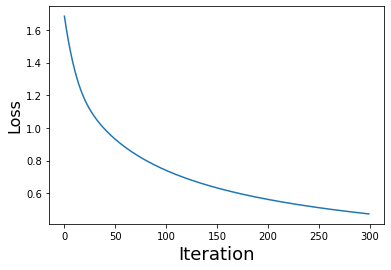

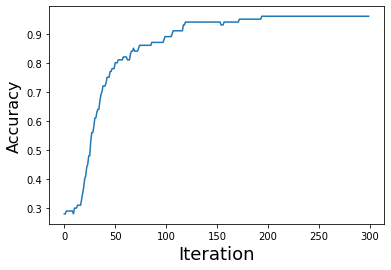

In [10]:
datapath = './Q3_data.npz'
data = np.load(datapath)

X = data['X']
Y = data['Y']
print(X.shape, Y.shape, np.unique(Y))
nin = X.shape[1]
nout = np.max(Y) + 1

x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

linear_model = LinearLayer(nin, nout)

train(x, y, linear_model, max_iteration=300, learning_rate=0.1)

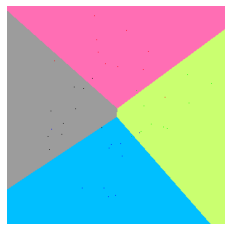

In [22]:
virtualization(X, Y, linear_model)

#Question 4

##a) Is this dataset linear separable?
load the dataset for this question and train a linear model on this dataset and report the performance

In [12]:
datapath = './Q4_data.npz'
data = np.load(datapath)

X = data['X']
Y = data['Y']

nin = X.shape[1]
nout = int(np.max(Y)) + 1

x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

iteration 19 loss: 0.7131081606665883 accuracy: 0.8
iteration 39 loss: 0.5328268063522784 accuracy: 0.825
iteration 59 loss: 0.47017925342992223 accuracy: 0.825
iteration 79 loss: 0.43818482919326157 accuracy: 0.825
iteration 99 loss: 0.41873421414176093 accuracy: 0.8
iteration 119 loss: 0.4056592012149814 accuracy: 0.8
iteration 139 loss: 0.3962662130872549 accuracy: 0.8
iteration 159 loss: 0.3891885082723314 accuracy: 0.8
iteration 179 loss: 0.38365851595216727 accuracy: 0.8
iteration 199 loss: 0.3792122607490226 accuracy: 0.8


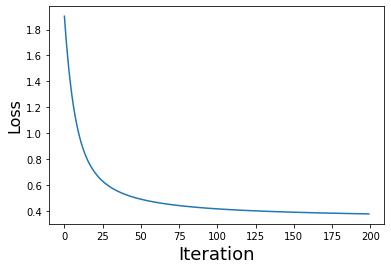

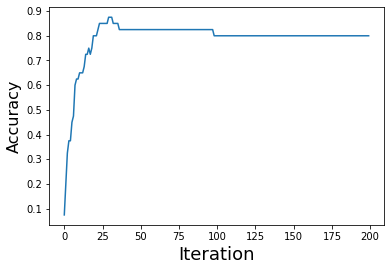

In [13]:
linear_model = LinearLayer(nin, nout)

train(x, y, linear_model, max_iteration=200, learning_rate=0.1)

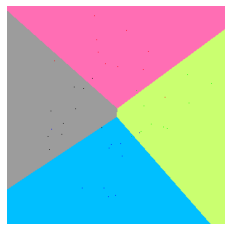

In [14]:
virtualization(X, Y, linear_model)

##b) Implementation of MLP
Implement a class of MLP to add arbitrary layers. You will need to implement the forward function to give out results `out` with `x` fed into the model.

In [18]:
class MLP(Module):
  def __init__(self, dimensions):
    '''We initialized several layers here in the list named self.linear_layers'''
    assert isinstance(dimensions, list)
    assert len(dimensions) > 2
    self.linear_layers = []
    for i in range(len(dimensions) - 1):
      self.linear_layers.append(LinearLayer(dimensions[i], dimensions[i+1]))

  def __call__(self, x):
    '''x is a two dimensional list of Values with shape (batch_size , nin)'''
    '''The output should be a two dimensional list of Values with shape (batch_size, nout)'''

    vrelu = np.vectorize(Value.relu)

    t = x
    layers = self.linear_layers.copy()
    last = layers.pop()

    for layer in layers:
      t = vrelu(layer(t)).tolist()

    return last(t)
  
  def parameters(self):
    return [p for layer in self.linear_layers for p in layer.parameters()]
  
  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0

Train your MLP model and visualize the decision boundary with ground truth points.

iteration 19 loss: 0.4906088355016522 accuracy: 0.825
iteration 39 loss: 0.4140424186092979 accuracy: 0.8
iteration 59 loss: 0.38606498836673775 accuracy: 0.8
iteration 79 loss: 0.367854064928107 accuracy: 0.8
iteration 99 loss: 0.3518138395992104 accuracy: 0.8
iteration 119 loss: 0.3396855465125144 accuracy: 0.8
iteration 139 loss: 0.32934272862603736 accuracy: 0.825
iteration 159 loss: 0.3196871190284037 accuracy: 0.825
iteration 179 loss: 0.31098374274175594 accuracy: 0.825
iteration 199 loss: 0.30325279645105535 accuracy: 0.85
iteration 219 loss: 0.2961121104131667 accuracy: 0.85
iteration 239 loss: 0.28952159863624527 accuracy: 0.85
iteration 259 loss: 0.2833712823305992 accuracy: 0.875
iteration 279 loss: 0.27768785315368705 accuracy: 0.9
iteration 299 loss: 0.2723506763056121 accuracy: 0.9


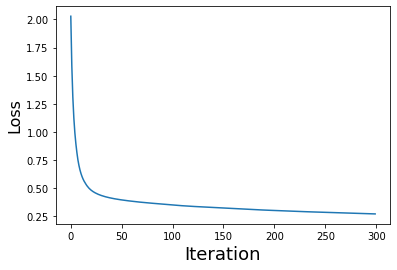

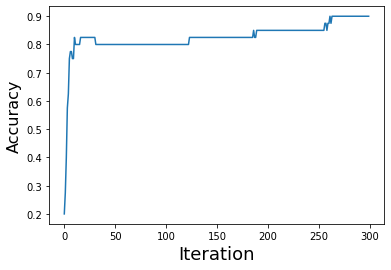

In [21]:
mlp_model = MLP([nin, 7, nout])
train(x, y, mlp_model, max_iteration=300, learning_rate=0.2)

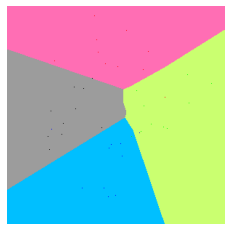

In [20]:
virtualization(X, Y, mlp_model)

#Acknowledgement

The design of the auto grade structure are based on the work https://github.com/karpathy/micrograd